# AROSICS 
Package for coregistration

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
from pyproj import Transformer
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, box

# Load refernce data
- SwissImage in EPSG 2056
- Reporject to EPSG 32632
- Interpolate to match S2 pixel alignment

In [2]:
# SwissImage

file_path = '../../data/swissimage-dop10_2022_2681-1253_2_2056.tif'
file_path2 = '../../data/swissimage-dop10_2022_2682-1253_2_2056.tif'
swissimage = rioxarray.open_rasterio(file_path)
swissimage2 = rioxarray.open_rasterio(file_path2)

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/pyproj/crs/_cf1x8.py:514: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(


In [3]:
def coords_to_topleft(ds, res):
  # Adjust coords to topleft corner of pixel
  x_coords = ds['x']
  y_coords = ds['y']

  ds = ds.assign_coords({'x': x_coords - res / 2, 'y': y_coords + res / 2})

  return ds

# Shift coords from center to topleft of pixel
swissimage = coords_to_topleft(swissimage, 2)
swissimage2 = coords_to_topleft(swissimage2, 2)

In [4]:
# Reproject to EPSG 32632
swissimage = swissimage.rio.reproject("EPSG:32632")
swissimage2 = swissimage2.rio.reproject("EPSG:32632")

In [5]:
def round_to_nearest_even(number):
    rounded = round(number)
    if rounded % 2 == 0:
        return rounded
    else:
        return rounded + 1 if number > rounded else rounded - 1

def round_to_higher_even(number):
    rounded = round(number)
    if rounded % 2 == 0:
        return rounded + 2
    else:
        return rounded + 1

def round_to_lower_even(number):
    rounded = round(number)
    if rounded % 2 == 0:
        return rounded
    else:
        return rounded - 1

In [6]:
# Resample to custom grid aligned with S2 data

start_x = round_to_lower_even(swissimage['x'].values[0]) 
end_x = round_to_higher_even(swissimage['x'].values[-1])
start_y = round_to_higher_even(swissimage['y'].values[0])
end_y = round_to_lower_even(swissimage['y'].values[-1])

new_x = np.arange(start_x, end_x+2, 2) # TO DO: then lengths should be fixed --> Actually should align to custom grid here!
new_y = np.arange(start_y, end_y-2, -2)

# Interpolate data
swissimage = swissimage.interp(x = new_x, y = new_y, method = "nearest")
swissimage = swissimage.rio.write_crs("epsg:32632")


start_x = round_to_lower_even(swissimage2['x'].values[0]) # TODO adapt use of higher or lower even nbr better
end_x = round_to_higher_even(swissimage2['x'].values[-1])
start_y = round_to_higher_even(swissimage2['y'].values[0])
end_y = round_to_lower_even(swissimage2['y'].values[-1])

new_x = np.arange(start_x, end_x+2, 2) # TO DO: then lengths should be fixed --> Actually should align to custom grid here!
new_y = np.arange(start_y, end_y-2, -2)

# Interpolate data
swissimage2 = swissimage2.interp(x = new_x, y = new_y, method = "nearest")
swissimage2 = swissimage2.rio.write_crs("epsg:32632")

In [7]:
def get_bounds_topleft_ds(ds, res):
  """
  Get bounds given that the coords are the topleft corner of the pixel
  """
  return ds.x.min().item(), ds.y.min().item() - res, ds.x.max().item() + res, ds.y.max().item()

<Axes: >

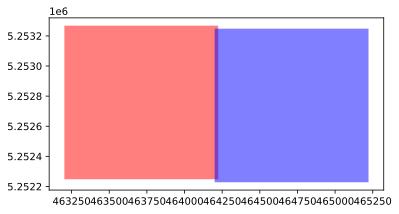

In [8]:
minx, miny, maxx, maxy = get_bounds_topleft_ds(swissimage, 2)
aoi = Polygon([(maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy), (maxx, maxy)])

minx, miny, maxx, maxy = get_bounds_topleft_ds(swissimage2, 2)
aoi2 = Polygon([(maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy), (maxx, maxy)])

gdf1 = gpd.GeoDataFrame(geometry=[aoi], crs=32632)
gdf2 = gpd.GeoDataFrame(geometry=[aoi2], crs=32632)

f, ax = plt.subplots(1,1,figsize=(6,6))
gdf1.plot(ax=ax, color='r', alpha=0.5)
gdf2.plot(ax=ax, color='b', alpha=0.5)

# Load target data (S2)
- Find data in same region as reference

In [9]:
# Find cube to register (corresponding AOI)

data_folder = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH')
cubes = [f for f in os.listdir(data_folder) if f.endswith('zarr')]
df_cubes = pd.DataFrame(cubes, columns=['file'])

# Extract location data

def extract_bounds_year(file):
    parts = file.split('_')
    minx = int(parts[1])
    maxx = minx + 1280
    maxy = int(parts[2])
    miny = maxy - 1280
    yr = int(parts[3][:4])
    return minx, miny, maxx, maxy, yr

# Apply the function to extract minx and maxy into new columns
df_cubes[['minx', 'miny', 'maxx', 'maxy', 'yr']] = df_cubes['file'].apply(lambda x: pd.Series(extract_bounds_year(x)))


# Filter files by bbox
""" 
transformer = Transformer.from_crs('EPSG:2056', 'EPSG:32632', always_xy=True)
minx, miny, maxx, maxy = swissimage.rio.bounds()
minx_utm, miny_utm = transformer.transform(minx, miny)
maxx_utm, maxy_utm = transformer.transform(maxx, maxy)
bbox_aoi = box(minx_utm, miny_utm, maxx_utm, maxy_utm)
"""
minx, miny, maxx, maxy = get_bounds_topleft_ds(swissimage, 2)
bbox_aoi = box(minx, miny, maxx, maxy)

# Function to check intersection
def intersects_with_bbox(row, bbox_aoi):
    file_polygon = box(row['minx'], row['miny'], row['maxx'], row['maxy'])
    return bbox_aoi.intersects(file_polygon)

filtered_files = df_cubes[df_cubes.apply(intersects_with_bbox, axis=1, bbox_aoi=bbox_aoi)]

# Filter files by year
filtered_files = filtered_files[filtered_files['yr'] == 2023]
filtered_filenames = filtered_files['file'].tolist()

In [10]:
filtered_filenames

['S2_462300_5254060_20230101_20231230.zarr',
 'S2_462300_5252780_20230101_20231230.zarr',
 'S2_463580_5254060_20230101_20231230.zarr',
 'S2_463580_5252780_20230101_20231230.zarr']

In [11]:
ds = xr.open_mfdataset([os.path.join(data_folder, f) for f in filtered_filenames], engine='zarr')

<Axes: >

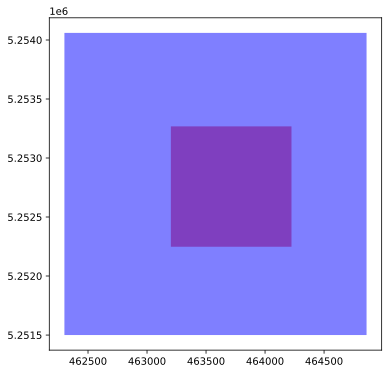

In [12]:
minx, miny, maxx, maxy = get_bounds_topleft_ds(swissimage, 2)
aoi = Polygon([(maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy), (maxx, maxy)])

minx, miny, maxx, maxy = get_bounds_topleft_ds(ds.rename({'lon':'x', 'lat':'y'}), 10)
aoi2 = Polygon([(maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy), (maxx, maxy)])

gdf1 = gpd.GeoDataFrame(geometry=[aoi], crs=32632)
gdf2 = gpd.GeoDataFrame(geometry=[aoi2], crs=32632)

f, ax = plt.subplots(1,1,figsize=(6,6))
gdf1.plot(ax=ax, color='r', alpha=0.5)
gdf2.plot(ax=ax, color='b', alpha=0.5)

In [14]:
# Crop SwissImage to S2 data resolution -> needs to be divisible by 10
# AND ensure that borders of SwissImage contained in S2 data

swissimage = swissimage.sel(x=slice(463210, 464220), y=slice(5253260, 5252250)) #TO CHECK
minx, miny, maxx, maxy = get_bounds_topleft_ds(swissimage, 2)
ds = ds.sel(lon=slice(minx-10, maxx+10), lat=slice(maxy+10, miny-10))

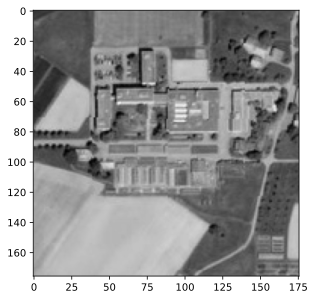

In [17]:
plt.imshow(swissimage[0].sel(x=slice(463390, 463740), y=slice(5253060, 5252710)), cmap='gray') #

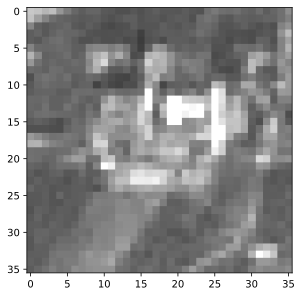

In [18]:
plt.imshow(ds.sel(lon=slice(463390, 463740), lat=slice(5253060, 5252710)).isel(time=15).s2_B02.values, cmap='gray', vmin=0, vmax=1000) #

# Clean data (clouds, missing...)

In [19]:
# Remove too many clouds (mask=1), shadows (mask=2) or snow (mask=3)

def has_clouds(ds):
    return (ds.s2_mask == 1).sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > 0.1

def has_shadows(ds):
    return (ds.s2_mask == 2).sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > 0.1

def has_snow(ds):
    return (ds.s2_mask == 3).sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > 0.1

def has_cirrus(ds):
    return ds.s2_B02.mean(['lat', 'lon']) > 1000

dates_to_drop = [date for date in ds.time.values if has_clouds(ds.sel(time=date))] + \
                [date for date in ds.time.values if has_shadows(ds.sel(time=date))] + \
                [date for date in ds.time.values if has_snow(ds.sel(time=date))] +\
                [date for date in ds.time.values if has_cirrus(ds.sel(time=date))]
ds = ds.drop_sel(time=dates_to_drop)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.026000000000000002..1.313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.5375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0485..1.3975000000000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2695..2.016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0365..1.7465].


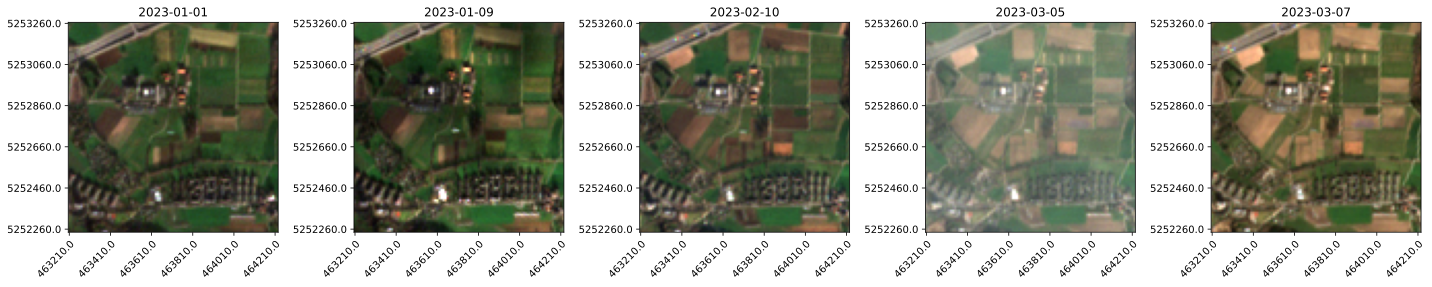

In [27]:
# Plot some RGB images

from matplotlib.ticker import MaxNLocator

mc_timeseries = ds.rename({'lon': 'x', 'lat': 'y'})

mc_timeseries = mc_timeseries.where(mc_timeseries != 65535, np.nan)

scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor

# Stack bands into an RGB array
rgb = xr.concat([r, g, b], dim='band').transpose('time', 'y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
brightness = 5

for i in range(5):
    axs[i].imshow(rgb[i].values * brightness, origin='upper')
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    #cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    #cbar.set_label('Brightness')

plt.tight_layout()
plt.show()

# Select reference and target images
- reference is SwissImage (Band 1 red)
- target is S2 stack (s2_B04)

In [20]:
reference_image = swissimage.isel(band=0)
bands = ['s2_B02', 's2_B03', 's2_B04', 's2_B05', 's2_B06', 's2_B07', 's2_B08', 's2_B8A', 's2_B09','s2_B11', 's2_B12']
target_images = ds[bands].compute()

# Perform global coregistration

In [21]:
from arosics import COREG, COREG_LOCAL
from geoarray import GeoArray
from arosics import COREG
from arosics import DESHIFTER
from pyproj import CRS
from shapely import Polygon

In [22]:
# Convert ref and target to GeoArray with some geo information

pixel_width_ref = 2 #abs(swissimage.x[1] - swissimage.x[0]).item()
pixel_height_ref = 2 #abs(swissimage.y[1] - swissimage.y[0]).item()
geotransform_ref = (swissimage.x.min().item(), pixel_width_ref, 0, swissimage.y.max().item(), 0, -pixel_height_ref)
projection_ref = swissimage.rio.crs.to_wkt()
geo_ref_image = GeoArray(reference_image.values.astype(np.float32), geotransform=geotransform_ref, projection=projection_ref)
minx, miny, maxx, maxy = [swissimage.x.min(), swissimage.y.min()-pixel_height_ref, swissimage.x.max()+pixel_width_ref, swissimage.y.max()]
footprint_ref = Polygon([(maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy), (maxx, maxy)])

pixel_width_tgt = abs(ds.lon[1] - ds.lon[0]).item()
pixel_height_tgt = abs(ds.lat[1] - ds.lat[0]).item()
geotransform_tgt = (target_images.lon.min().item(), pixel_width_tgt, 0, target_images.lat.max().item(), 0, -pixel_height_tgt)
projection_tgt = CRS.from_epsg(32632).to_wkt()
minx, miny, maxx, maxy = [ds.lon.min(), ds.lat.min()-pixel_height_tgt, ds.lon.max()+pixel_width_tgt, ds.lat.max()]
footprint_tgt = Polygon([(maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy), (maxx, maxy)])

In [23]:
from scipy.ndimage import affine_transform

# Function to apply affine transformation based on shifts
def apply_shifts(image, shifts, output_shape):
    matrix = np.array([[1, 0, shifts[0]], [0, 1, shifts[1]], [0, 0, 1]])
    transformed_image = np.zeros(output_shape, dtype=image.dtype)
    for band in range(image.shape[2]):
        transformed_image[:, :, band] = affine_transform(image[:, :, band], matrix, order=1, mode='nearest', output_shape=output_shape[:2])
    return transformed_image

In [24]:
# Global coregistration

corrected_images_stack = []

for i in range(target_images.sizes['time']):
    
    print(f'Coregistering image {i}, time {str(ds.time.values[i])}')
    
    target_image = target_images.isel(time=i)
    geo_tgt_image = GeoArray(target_image.to_array().values.transpose(1, 2, 0), geotransform=geotransform_tgt, projection=projection_tgt)
    
    # Pass cloud mask
    scl = ds.isel(time=i).s2_SCL
    scl_mask = xr.where(scl.isin([0,1,2,3,7,8,9,10]), True, False) 
    cloud = ds.isel(time=i).s2_mask
    cloud_mask = xr.where(cloud != 0, True, False)
    data_mask = scl_mask & cloud_mask
    
    # Check if there is any data
    print(f'Clouds masked {data_mask.values.sum()}/{data_mask.shape[0]*data_mask.shape[1]}')
    print(f'Missing data: {np.sum(target_image.values == 65535)}')
    if not data_mask.values.sum() == data_mask.shape[0]*data_mask.shape[1]: 
        try:

            # Initialize the COREG object
            CR = COREG(
                im_ref=geo_ref_image,  # Reference image array
                im_tgt=geo_tgt_image, #target_image.to_array().values.transpose(1, 2, 0),     # Target image array
                ws=(80,80),           # Size of the matching window
                max_iter=10,             # Maximum number of iterations
                path_out=None,           # Path to save the coregistered image (None if not saving)
                fmt_out='Zarr',             # Output format (None if not saving)
                nodata = (255, 65535),
                #mask_baddata_tgt= data_mask.values,
                footprint_poly_ref=footprint_ref,
                footprint_poly_tgt=footprint_tgt,
                align_grids=True,
            )

            # Compute shifts
            CR.calculate_spatial_shifts()
            
            #corrected_dict = DESHIFTER(geo_tgt_image, CR.coreg_info, cliptoextent=True).correct_shifts() #CR.correct_shifts() # returns an OrderedDict containing the co-registered numpy array and its corresponding geoinformation.
            #print(corrected_dict['arr_shifted'].shape)

            corrected_dict = CR.correct_shifts() # returns an OrderedDict containing the co-registered numpy array and its corresponding geoinformation.

            """ 
            # Apply shifts to adjust pixel values
            shift_x, shift_y = CR.coreg_info['corrected_shifts_px']['x'],  CR.coreg_info['corrected_shifts_px']['y']
            target_array = geo_tgt_image.arr
            corrected_image = apply_shifts(target_array, [shift_x, shift_y], target_array.shape)  
            #ds_coreg = apply_shifts_ds(target_array, [shift_x, shift_y], target_array.shape)  
            """
            """ 
            # Update ds_coreg at time i with coregistered values
            for band in bands:
                ds_coreg[band].isel(time=i).values[:] = corrected_image[:, :, bands.index(band)].astype(np.float32) #corrected_dict['arr_shifted'][:, :, bands.index(band)].astype(np.float32)
            """
            corrected_images_stack.append(corrected_dict['arr_shifted'])
           
        except Exception as e:
            print(f'Error: {e}')
            corrected_images_stack.append(geo_tgt_image.arr)
            pass
  

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Coregistering image 0, time 2023-01-01T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/-1
Detected subpixel shifts (X/Y):                           -0.3993728351950534/0.23605336573898492
Calculated total shifts in fft pixel units (X/Y):         -0.3993728351950534/-0.7639466342610151
Calculated total shifts in reference pixel units (X/Y):   -0.3993728351950534/-0.7639466342610151
Calculated total shifts in target pixel units (X/Y):      -0.3993728351950534/-0.7639466342610151
Calculated map shifts (X,Y):				  -3.993728351953905/7.6394663425162435
Calculated absolute shift vector length in map units:     8.620400927314169
Calculated angle of shift vector in degree

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |=============================================-----| 90.4% Complete  => 0:00:00

Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.16121687969230716/0.3560261333722101
Calculated total shifts in fft pixel units (X/Y):         0.16121687969230716/0.3560261333722101
Calculated total shifts in reference pixel units (X/Y):   0.16121687969230716/0.3560261333722101
Calculated total shifts in target pixel units (X/Y):      0.16121687969230716/0.3560261333722101
Calculated map shifts (X,Y):				  1.6121687969425693/-3.560261333361268
Calculated absolute shift vector length in map units:     3.908266750320736
Calculated angle of shift vector in degrees from North:   335.63788104745487
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463201.61216879694', '5253266.439738667', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after cor

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Coregistering image 3, time 2023-03-05T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.29089946988104204/0.19961258392737843
Calculated total shifts in fft pixel units (X/Y):         -0.29089946988104204/0.19961258392737843
Calculated total shifts in reference pixel units (X/Y):   -0.29089946988104204/0.19961258392737843
Calculated total shifts in target pixel units (X/Y):      -0.29089946988104204/0.19961258392737843
Calculated map shifts (X,Y):				  -2.9089946988387965/-1.996125839650631
Calculated absolute shift vector length in map units:     3.527997806914448
Calculated angle of shift vector in de

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |================================------------------| 64.4% Complete  => 0:00:00

Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.2850028596759373/0.2132328753846088
Calculated total shifts in fft pixel units (X/Y):         -0.2850028596759373/0.2132328753846088
Calculated total shifts in reference pixel units (X/Y):   -0.2850028596759373/0.2132328753846088
Calculated total shifts in target pixel units (X/Y):      -0.2850028596759373/0.2132328753846088
Calculated map shifts (X,Y):				  -2.8500285967602395/-2.1323287542909384
Calculated absolute shift vector length in map units:     3.5594225541128273
Calculated angle of shift vector in degrees from North:   53.19697151570072
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463197.14997140324', '5253267.867671246', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after correction): 0.1386 => 0.1515
Estimated reliability 

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Coregistering image 6, time 2023-04-04T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.06171826912435779/0.2197868487369612
Calculated total shifts in fft pixel units (X/Y):         0.06171826912435779/0.2197868487369612
Calculated total shifts in reference pixel units (X/Y):   0.06171826912435779/0.2197868487369612
Calculated total shifts in target pixel units (X/Y):      0.06171826912435779/0.2197868487369612
Calculated map shifts (X,Y):				  0.6171826912323013/-2.1978684877976775
Calculated absolute shift vector length in map units:     2.282879840028992
Calculated angle of shift vector in degrees fr

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.23170621203218003/0.22641424539497126
Calculated total shifts in fft pixel units (X/Y):         -0.23170621203218003/0.22641424539497126
Calculated total shifts in reference pixel units (X/Y):   -0.23170621203218003/0.22641424539497126
Calculated total shifts in target pixel units (X/Y):      -0.23170621203218003/0.22641424539497126
Calculated map shifts (X,Y):				  -2.3170621203025803/-2.2641424536705017
Calculated absolute shift vector length in map units:     3.2396169402962087
Calculated angle of shift vector in degrees from North:   45.66182128190371
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================----------------| 67.3% Complete  => 0:00:00

Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.25666516034707487/0.10530677134314538
Calculated total shifts in fft pixel units (X/Y):         -0.25666516034707487/0.10530677134314538
Calculated total shifts in reference pixel units (X/Y):   -0.25666516034707487/0.10530677134314538
Calculated total shifts in target pixel units (X/Y):      -0.25666516034707487/0.10530677134314538
Calculated map shifts (X,Y):				  -2.5666516034980305/-1.0530677130445838
Calculated absolute shift vector length in map units:     2.774284062960381
Calculated angle of shift vector in degrees from North:   67.69221975960436
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463197.4333483965', '5253268.946932287', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after correction): 0.1007 => 0.1094
Estimated reliab

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Coregistering image 10, time 2023-05-06T00:00:00.000000000
Clouds masked 969/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.3339034528692404/-0.18976588975667888
Calculated total shifts in fft pixel units (X/Y):         -0.3339034528692404/-0.18976588975667888
Calculated total shifts in reference pixel units (X/Y):   -0.3339034528692404/-0.18976588975667888
Calculated total shifts in target pixel units (X/Y):      -0.3339034528692404/-0.18976588975667888
Calculated map shifts (X,Y):				  -3.33903452870436/1.8976588975638151
Calculated absolute shift vector length in map units:     3.8406068368661566
Calculated angle of shift vector in 

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |=========================-------------------------| 49.0% Complete  => 0:00:00

Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.34222846761426956/0.18892651871722108
Calculated total shifts in fft pixel units (X/Y):         -0.34222846761426956/0.18892651871722108
Calculated total shifts in reference pixel units (X/Y):   -0.34222846761426956/0.18892651871722108
Calculated total shifts in target pixel units (X/Y):      -0.34222846761426956/0.18892651871722108
Calculated map shifts (X,Y):				  -3.422284676169511/-1.8892651870846748
Calculated absolute shift vector length in map units:     3.909137417880669
Calculated angle of shift vector in degrees from North:   61.099197403577854
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463196.57771532383', '5253268.110734813', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after correction): 0.2265 => 0.2441
Estimated relia

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Coregistering image 13, time 2023-05-29T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.4944825351445673/0.1465276092964342
Calculated total shifts in fft pixel units (X/Y):         -0.4944825351445673/0.1465276092964342
Calculated total shifts in reference pixel units (X/Y):   -0.4944825351445673/0.1465276092964342
Calculated total shifts in target pixel units (X/Y):      -0.4944825351445673/0.1465276092964342
Calculated map shifts (X,Y):				  -4.944825351471081/-1.4652760932222009
Calculated absolute shift vector length in map units:     5.157357054337
Calculated angle of shift vector in degrees from

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.33672181563768394/-0.07560602942077728
Calculated total shifts in fft pixel units (X/Y):         -0.33672181563768394/-0.07560602942077728
Calculated total shifts in reference pixel units (X/Y):   -0.33672181563768394/-0.07560602942077728
Calculated total shifts in target pixel units (X/Y):      -0.33672181563768394/-0.07560602942077728
Calculated map shifts (X,Y):				  -3.3672181564033963/0.7560602938756347
Calculated absolute shift vector length in map units:     3.4510556762805202
Calculated angle of shift vector in degrees from North:   102.6550540559021
Original map info: ['UTM', 1.0, 1.0, 463200.0, 525327

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |=====================================-------------| 73.1% Complete  => 0:00:00

Image similarity within the matching window (SSIM before/after correction): 0.1922 => 0.2050
Estimated reliability of the calculated shifts:  63.1 %
Correcting geometric shifts...
Coregistering image 16, time 2023-06-05T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.3129900213717391/-0.18616917227235452
Calculated total shifts in fft pixel units (X/Y):         -0.3129900213717391/-0.18616917227235452
Calculated total shifts in reference pixel units (X/Y):   -0.3129900213717391/-0.18616917227235452
Calculated total shifts in target pixel units (X/Y):      -0.3129900213717391/-0.18616917227235452
Calcul

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Coregistering image 17, time 2023-06-08T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.327738029305538/0.19168412282918923
Calculated total shifts in fft pixel units (X/Y):         -0.327738029305538/0.19168412282918923
Calculated total shifts in reference pixel units (X/Y):   -0.327738029305538/0.19168412282918923
Calculated total shifts in target pixel units (X/Y):      -0.327738029305538/0.19168412282918923
Calculated map shifts (X,Y):				  -3.27738029306056/-1.916841228492558
Calculated absolute shift vector length in map units:     3.796775194897715
Calculated angle of shift vector in degrees fro

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.3810198276858218/-0.044970973046818054
Calculated total shifts in fft pixel units (X/Y):         -0.3810198276858218/-0.044970973046818054
Calculated total shifts in reference pixel units (X/Y):   -0.3810198276858218/-0.044970973046818054
Calculated total shifts in target pixel units (X/Y):      -0.3810198276858218/-0.044970973046818054
Calculated map shifts (X,Y):				  -3.810198276885785/0.44970973022282124
Calculated absolute shift vector length in map units:     3.836645637876984
Calculated angle of shift vector in degrees from North:   96.73135898971998
Original map inf

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.22161146674088505/-0.1240396345413677
Calculated total shifts in fft pixel units (X/Y):         -0.22161146674088505/-0.1240396345413677
Calculated total shifts in reference pixel units (X/Y):   -0.22161146674088505/-0.1240396345413677
Calculated total shifts in target pixel units (X/Y):      -0.22161146674088505/-0.1240396345413677
Calculated map shifts (X,Y):				  -2.2161146674188785/1.2403963450342417
Calculated absolute shift vector length in map units:     2.5396352714363126
Calculated angle of shift vector in degrees from North:   119.23646719526093
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==============------------------------------------| 28.8% Complete  => 0:00:00

Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.3138925207518896/0.10622664257635119
Calculated total shifts in fft pixel units (X/Y):         -0.3138925207518896/0.10622664257635119
Calculated total shifts in reference pixel units (X/Y):   -0.3138925207518896/0.10622664257635119
Calculated total shifts in target pixel units (X/Y):      -0.3138925207518896/0.10622664257635119
Calculated map shifts (X,Y):				  -3.138925207545981/-1.0622664261609316
Calculated absolute shift vector length in map units:     3.3137986388307143
Calculated angle of shift vector in degrees from North:   71.30329413382285
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463196.86107479245', '5253268.937733574', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after correction): 0.2862 => 0.3031
Estimated reliabili

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Coregistering image 22, time 2023-07-15T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.23532010929646113/0.08150990932401217
Calculated total shifts in fft pixel units (X/Y):         -0.23532010929646113/0.08150990932401217
Calculated total shifts in reference pixel units (X/Y):   -0.23532010929646113/0.08150990932401217
Calculated total shifts in target pixel units (X/Y):      -0.23532010929646113/0.08150990932401217
Calculated map shifts (X,Y):				  -2.3532010929775424/-0.815099093131721
Calculated absolute shift vector length in map units:     2.4903698351078005
Calculated angle of shift vector in 

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.2752099278513511/0.3460816978627649
Calculated total shifts in fft pixel units (X/Y):         -0.2752099278513511/0.3460816978627649
Calculated total shifts in reference pixel units (X/Y):   -0.2752099278513511/0.3460816978627649
Calculated total shifts in target pixel units (X/Y):      -0.2752099278513511/0.3460816978627649
Calculated map shifts (X,Y):				  -2.7520992784993723/-3.4608169784769416
Calculated absolute shift vector length in map units:     4.421685718957311
Calculated angle of shift vector in degrees from North:   38.49230455875707
Original map info: ['UTM', 

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |======--------------------------------------------| 12.5% Complete  => 0:00:00

Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.2739075478489341/-0.2121440236519299
Calculated total shifts in fft pixel units (X/Y):         -0.2739075478489341/-0.2121440236519299
Calculated total shifts in reference pixel units (X/Y):   -0.2739075478489341/-0.2121440236519299
Calculated total shifts in target pixel units (X/Y):      -0.2739075478489341/-0.2121440236519299
Calculated map shifts (X,Y):				  -2.7390754785155877/2.121440236456692
Calculated absolute shift vector length in map units:     3.4645408287192723
Calculated angle of shift vector in degrees from North:   127.75812561977793
Original map info: ['UT

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Coregistering image 26, time 2023-08-17T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.3574443938487616/0.20259818657825016
Calculated total shifts in fft pixel units (X/Y):         -0.3574443938487616/0.20259818657825016
Calculated total shifts in reference pixel units (X/Y):   -0.3574443938487616/0.20259818657825016
Calculated total shifts in target pixel units (X/Y):      -0.3574443938487616/0.20259818657825016
Calculated map shifts (X,Y):				  -3.574443938501645/-2.025981865823269
Calculated absolute shift vector length in map units:     4.1086800788253015
Calculated angle of shift vector in degre

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Image similarity within the matching window (SSIM before/after correction): 0.3090 => 0.3218
Estimated reliability of the calculated shifts:  62.9 %
Correcting geometric shifts...
Coregistering image 28, time 2023-08-22T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.11409062639695158/0.22365549715103922
Calculated total shifts in fft pixel units (X/Y):         -0.11409062639695158/0.22365549715103922
Calculated total shifts in reference pixel units (X/Y):   -0.11409062639695158/0.22365549715103922
Calculated total shifts in target pixel units (X/Y):      -0.11409062639695158/0.22365549715103922
Calcul

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            -1/0
Detected subpixel shifts (X/Y):                           0.1765503181886292/-0.13689507109286692
Calculated total shifts in fft pixel units (X/Y):         -0.8234496818113708/-0.13689507109286692
Calculated total shifts in reference pixel units (X/Y):   -0.8234496818113708/-0.13689507109286692
Calculated total shifts in target pixel units (X/Y):      -0.8234496818113708/-0.13689507109286692
Calculated map shifts (X,Y):				  -8.234496818098705/1.368950710631907
Calculated absolute shift vector length in map units:     8.347512437571885
Calculated angle of shift vector in degrees from North:   99.43885980366684
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Coregistering image 31, time 2023-09-06T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.23131053582507632/0.13582925401599558
Calculated total shifts in fft pixel units (X/Y):         -0.23131053582507632/0.13582925401599558
Calculated total shifts in reference pixel units (X/Y):   -0.23131053582507632/0.13582925401599558
Calculated total shifts in target pixel units (X/Y):      -0.23131053582507632/0.13582925401599558
Calculated map shifts (X,Y):				  -2.313105358276516/-1.3582925405353308
Calculated absolute shift vector length in map units:     2.6824270771376906
Calculated angle of shift vector in 

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Image similarity within the matching window (SSIM before/after correction): 0.2066 => 0.2158
Estimated reliability of the calculated shifts:  63.4 %
Correcting geometric shifts...
Coregistering image 33, time 2023-09-11T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.131025149469245/-0.06104874452278323
Calculated total shifts in fft pixel units (X/Y):         -0.131025149469245/-0.06104874452278323
Calculated total shifts in reference pixel units (X/Y):   -0.131025149469245/-0.06104874452278323
Calculated total shifts in target pixel units (X/Y):      -0.131025149469245/-0.06104874452278323
Calculated

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |=============================================-----| 90.4% Complete  => 0:00:00

Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.30658051677201426/0.1314995284096918
Calculated total shifts in fft pixel units (X/Y):         -0.30658051677201426/0.1314995284096918
Calculated total shifts in reference pixel units (X/Y):   -0.30658051677201426/0.1314995284096918
Calculated total shifts in target pixel units (X/Y):      -0.30658051677201426/0.1314995284096918
Calculated map shifts (X,Y):				  -3.065805167716462/-1.314995284192264
Calculated absolute shift vector length in map units:     3.335921750258069
Calculated angle of shift vector in degrees from North:   66.78437907331785
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0,

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Coregistering image 36, time 2023-09-26T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.3305030545994316/0.1134300651960538
Calculated total shifts in fft pixel units (X/Y):         -0.3305030545994316/0.1134300651960538
Calculated total shifts in reference pixel units (X/Y):   -0.3305030545994316/0.1134300651960538
Calculated total shifts in target pixel units (X/Y):      -0.3305030545994316/0.1134300651960538
Calculated map shifts (X,Y):				  -3.3050305459764786/-1.134300651960075
Calculated absolute shift vector length in map units:     3.4942617072673063
Calculated angle of shift vector in degrees 

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |======================================------------| 76.9% Complete  => 0:00:00

Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.3440339327654503/-0.04392573143515793
Calculated total shifts in fft pixel units (X/Y):         -0.3440339327654503/-0.04392573143515793
Calculated total shifts in reference pixel units (X/Y):   -0.3440339327654503/-0.04392573143515793
Calculated total shifts in target pixel units (X/Y):      -0.3440339327654503/-0.04392573143515793
Calculated map shifts (X,Y):				  -3.4403393276734278/0.4392573144286871
Calculated absolute shift vector length in map units:     3.468267820946871
Calculated angle of shift vector in degrees from North:   97.27607109271662
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463196.5596606723', '5253270.439257314', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after correction): 0.1026 => 0.1101
Estimated reliabi

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Coregistering image 39, time 2023-10-08T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.24376991737613624/-0.20652540332905003
Calculated total shifts in fft pixel units (X/Y):         -0.24376991737613624/-0.20652540332905003
Calculated total shifts in reference pixel units (X/Y):   -0.24376991737613624/-0.20652540332905003
Calculated total shifts in target pixel units (X/Y):      -0.24376991737613624/-0.20652540332905003
Calculated map shifts (X,Y):				  -2.437699173751753/2.0652540335431695
Calculated absolute shift vector length in map units:     3.194941546378636
Calculated angle of shift vector i

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |=======================================-----------| 77.9% Complete  => 0:00:00

Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.16956418426913752/-0.30452896992407663
Calculated total shifts in fft pixel units (X/Y):         -0.16956418426913752/-0.30452896992407663
Calculated total shifts in reference pixel units (X/Y):   -0.16956418426913752/-0.30452896992407663
Calculated total shifts in target pixel units (X/Y):      -0.16956418426913752/-0.30452896992407663
Calculated map shifts (X,Y):				  -1.6956418426707387/3.0452896989881992
Calculated absolute shift vector length in map units:     3.4855402177251458
Calculated angle of shift vector in degrees from North:   150.8905872284793
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463198.30435815733', '5253273.045289699', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after correction): 0.0189 => 0.0199
Estimated r

Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Coregistering image 42, time 2023-10-16T00:00:00.000000000
Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.26153487531010006/0.1495697142235096
Calculated total shifts in fft pixel units (X/Y):         -0.26153487531010006/0.1495697142235096
Calculated total shifts in reference pixel units (X/Y):   -0.26153487531010006/0.1495697142235096
Calculated total shifts in target pixel units (X/Y):      -0.26153487531010006/0.1495697142235096
Calculated map shifts (X,Y):				  -2.6153487531119026/-1.4956971425563097
Calculated absolute shift vector length in map units:     3.012832395380648
Calculated angle of shift vector in degr

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.4192374064797619/-0.25755612503413844
Calculated total shifts in fft pixel units (X/Y):         -0.4192374064797619/-0.25755612503413844
Calculated total shifts in reference pixel units (X/Y):   -0.4192374064797619/-0.25755612503413844
Calculated total shifts in target pixel units (X/Y):      -0.4192374064797619/-0.25755612503413844
Calculated map shifts (X,Y):				  -4.192374064819887/2.5755612505599856
Calculated absolute shift vector length in map units:     4.920316662041229
Calculated angle of shift vector in degrees from North:   121.56425025557206
Original map info: ['UTM', 1.0, 1.0, 463200.0, 5253270.0, 10.0, 10.0, 32, 'North', 'WGS-84']
Updated map info:  ['UTM', 1.0, 1.0, '463195.8076259352', '5253272.575561251', 10.0, 10.0, 32, 'North', 'WGS-84']
Image similarity within the matching window (SSIM before/after correction): 0.0739 => 0.0781
Estimated reliabi

/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/geoarray/baseclasses.py:719: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Clouds masked 0/10816
Missing data: 0
Bounding box of calculated footprint for reference image:
	(463210.0, 5252248.0, 464222.0, 5253260.0)
Bounding box of calculated footprint for image to be shifted:
	(463200.0, 5252230.0, 464240.0, 5253270.0)
Matching window position (X,Y): 463716.0/5252754.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           0.1548625495805394/-0.15175134079710806
Calculated total shifts in fft pixel units (X/Y):         0.1548625495805394/-0.15175134079710806
Calculated total shifts in reference pixel units (X/Y):   0.1548625495805394/-0.15175134079710806
Calculated total shifts in target pixel units (X/Y):      0.1548625495805394/-0.15175134079710806
Calculated map shifts (X,Y):				  1.5486254958086647/1.5175134083256125
Calculated absolute shift vector length in map units:     2.1681992230227944
Calculated angle of shift vector in degrees from North:   225.5813598812933
Original map info: ['UTM

In [25]:
# Convert list to NumPy array
corrected_images_stack = np.stack(corrected_images_stack, axis=0).transpose((3,0,1,2))  # Final shape is (bands, time, lat, lon)

In [26]:
corrected_images_stack.shape

(11, 46, 104, 104)

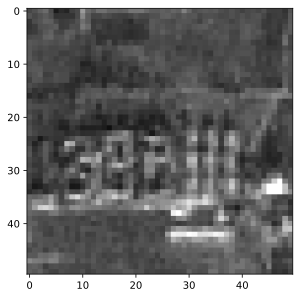

In [22]:
plt.imshow(corrected_images_stack[0,0,-50:,-50:], cmap='gray', vmin=0, vmax=1000)

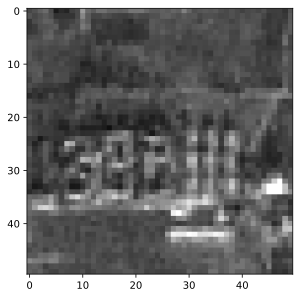

In [23]:
plt.imshow(ds.isel(time=0)['s2_B02'][-50:, -50:], cmap='gray', vmin=0, vmax=1000)

In [27]:
# Create a new xarray Dataset

time_dim = ds.sizes['time']
lat_dim = ds.sizes['lat']
lon_dim = ds.sizes['lon']
bands_dim = len(bands)  # Number of bands

# Create DataArray for each band
data_vars = {band: xr.DataArray(
    data=corrected_images_stack[bands.index(band),:, :, :],
    dims=['time','lat','lon',],
    coords={'lon': ds['lon'].values, 'lat': ds['lat'].values, 'time': ds['time'].values},
    name=band
) for band in bands}

# Create Dataset
ds_coreg = xr.Dataset(data_vars=data_vars)

In [28]:
non_bands = ['mean_sensor_azimuth', 'mean_sensor_zenith', 'mean_solar_azimuth', 'mean_solar_zenith', 'product_uri', 's2_AOT', 's2_B01', 's2_SCL', 's2_WVP', 's2_mask']
ds_coreg[non_bands] =ds[non_bands].compute()

In [29]:
ds_coreg

<xarray.Dataset> Size: 153MB
Dimensions:              (lon: 104, lat: 104, time: 46)
Coordinates:
  * lon                  (lon) float64 832B 4.632e+05 4.632e+05 ... 4.642e+05
  * lat                  (lat) float64 832B 5.253e+06 5.253e+06 ... 5.252e+06
  * time                 (time) datetime64[ns] 368B 2023-01-01 ... 2023-12-30
Data variables: (12/21)
    s2_B02               (time, lat, lon) uint16 995kB 334 365 402 ... 402 295
    s2_B03               (time, lat, lon) uint16 995kB 582 593 595 ... 636 553
    s2_B04               (time, lat, lon) uint16 995kB 360 412 476 ... 687 474
    s2_B05               (time, lat, lon) uint16 995kB 963 996 1044 ... 998 987
    s2_B06               (time, lat, lon) uint16 995kB 2268 2422 ... 2128 2173
    s2_B07               (time, lat, lon) uint16 995kB 2983 2947 ... 2404 2449
    ...                   ...
    product_uri          (lon, lat, time) <U65 129MB 'S2B_MSIL2A_20230101T102...
    s2_AOT               (time, lat, lon) uint16 995kB 118 118 118 ... 79 79 79
    s2_B01               (time, lat, lon) uint16 995kB 84 84 84 ... 153 147 147
    s2_SCL               (time, lat, lon) uint16 995kB 4 4 4 4 4 4 ... 4 4 4 4 4
    s2_WVP               (time, lat, lon) uint16 995kB 1357 1357 ... 1061 1061
    s2_mask              (time, lat, lon) uint16 995kB 0 0 0 0 0 0 ... 0 0 0 0 0

# Test: Shift images

In [8]:
def translate_right(image_data, shift=1):
    # Create a shifted version of the image
    translated_image = np.roll(image_data, shift, axis=-1)
    # Zero out the newly introduced pixels (to avoid wrap-around effects)
    translated_image[..., :shift] = 0
    return translated_image


""" 
from scipy.ndimage import shift

def translate_right(image_data, shift_value=0.5):
    # Shift the image to the right by shift_value pixels
    translated_image = shift(image_data, shift=[0, shift_value], mode='constant', cval=0)
    return translated_image
"""

" \nfrom scipy.ndimage import shift\n\ndef translate_right(image_data, shift_value=0.5):\n    # Shift the image to the right by shift_value pixels\n    translated_image = shift(image_data, shift=[0, shift_value], mode='constant', cval=0)\n    return translated_image\n"

In [9]:
# Apply translation to each image in the DataArray
translated_data_array = target_images.s2_B04.copy()  # Copy to avoid modifying the original data
for t in range(translated_data_array.sizes['time']):
    translated_data_array[t, :, :] = translate_right(translated_data_array[t, :, :])

In [16]:
from arosics import COREG_LOCAL
from geoarray import GeoArray
from pyproj import CRS


# Convert reference image to GeoArray
geotransform = (ds.lon.min().values, 10, 0, ds.lat.max().values, 0, -10)
projection = CRS.from_epsg(32632).to_wkt()
geo_ref_image = GeoArray(target_images.s2_B04[0].values, geotransform=geotransform, projection=projection)

# Loop through each target image and perform coregistration
for i in range(translated_data_array.shape[0]):
    target_image = translated_data_array[i, :,:]
    geo_tgt_image = GeoArray(target_image.values, geotransform=geotransform, projection=projection)


    # Initialize the COREG object
    CR = COREG_LOCAL(
        im_ref=geo_ref_image,  # Reference image array
        im_tgt=geo_tgt_image,     # Target image array
        grid_res=10,           # Target grid resolution
        window_size=(256,256),        # Size of the matching window
        fmt_out='Zarr',
        nodata=(65535,65535)
    )

    # Perform coregistration
    corrected_dict = CR.correct_shifts() # returns an OrderedDict containing the co-registered numpy array and its corresponding geoinformation.


    # If you want to save the corrected image or do further processing,
    # proceed with your own logic here.


    break

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(462300.0, 5251500.0, 464860.0, 5254060.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(462300.0, 5251500.0, 464860.0, 5254060.0)
Matching window position (X,Y): 463580.0/5252780.0
Initializing tie points grid...
Calculating tie point grid (676 points) using 64 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:05
/home/f80873755@agsad.admin.ch/.virtualenvs/arosics/lib/python3.11/site-packages/arosics/Tie_Point_Grid.py:382: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF = GDF.fillna(self.outFillVal)


Found 676 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
0 tie points flagged by level 2 filtering (SSIM).


Translating progress |==================================================| 100.0% Complete  => 0:00:00


0 tie points flagged by level 3 filtering (RANSAC)
676 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:07


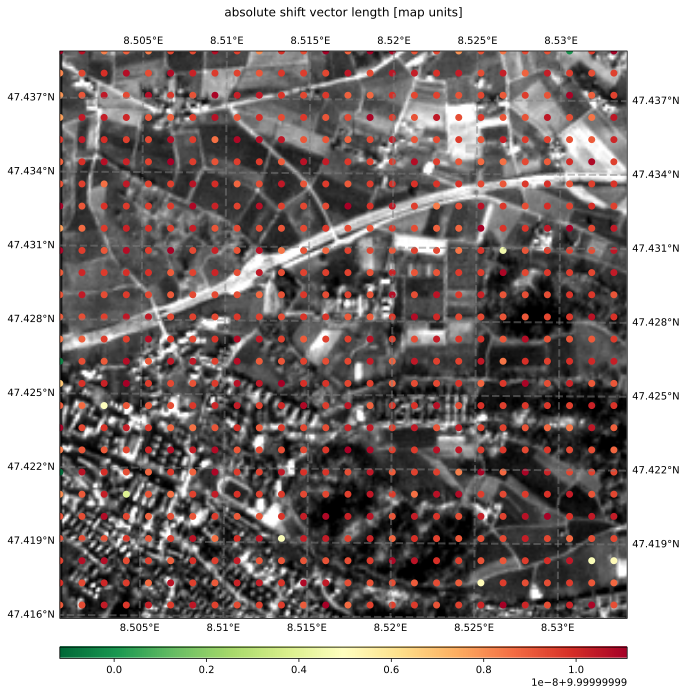

In [24]:
CR.view_CoRegPoints(figsize=(10,10), backgroundIm='tgt')

In [22]:
from arosics import COREG
from geoarray import GeoArray
from pyproj import CRS


# Convert reference image to GeoArray
geotransform = (ds.lon.min().values, 10, 0, ds.lat.max().values, 0, -10)
projection = CRS.from_epsg(32632).to_wkt()
geo_ref_image = GeoArray(target_images.s2_B04[0].values, geotransform=geotransform, projection=projection)

# Loop through each target image and perform coregistration
for i in range(translated_data_array.shape[0]):
    target_image = translated_data_array[i, :,:]
    geo_tgt_image = GeoArray(target_image.values, geotransform=geotransform, projection=projection)


    # Initialize the COREG object
    CR = COREG(
        im_ref=geo_ref_image,  # Reference image array
        im_tgt=geo_tgt_image,     # Target image array
        ws=(256,256),        # Size of the matching window
        max_iter=10,             # Maximum number of iterations
        path_out=None,           # Path to save the coregistered image (None if not saving)
        fmt_out='Zarr',             # Output format (None if not saving)
        nodata=(65535,65535)
    )

    # Perform coregistration
    CR.calculate_spatial_shifts()
    corrected_dict = CR.correct_shifts()

    break

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(462300.0, 5251500.0, 464860.0, 5254060.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(462300.0, 5251500.0, 464860.0, 5254060.0)
Matching window position (X,Y): 463580.0/5252780.0
Detected integer shifts (X/Y):                            -1/0
Detected subpixel shifts (X/Y):                           5.6675948656437214e-11/4.94320084865052e-10
Calculated total shifts in fft pixel units (X/Y):         -0.999999999943324/4.94320084865052e-10
Calculated total shifts in reference pixel units (X/Y):   -0.999999999943324/4.94320084865052e-10
Calculated total shifts in target pixel units (X/Y):      -0.999999999943324/4.94320084865052e-10
Calculated map shifts (X,Y):				  -9.999999999417923/-4.6566128730773926e-09
Calculated absolute shift

In [33]:
from arosics import DESHIFTER
test = DESHIFTER(geo_tgt_image, CR.coreg_info, align_grids=True).correct_shifts()

Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Correcting geometric shifts...


In [29]:
corrected_dict['arr_shifted']

array([[   0,  510,  431, ...,  422,  552,  791],
       [   0,  664,  553, ...,  538,  720, 1030],
       [   0,  586,  692, ...,  811,  981,  955],
       ...,
       [   0,  436,  343, ...,  179,  280,  336],
       [   0,  402,  340, ...,  195,  334,  325],
       [   0,  255,  322, ...,  229,  222,  196]], dtype=uint16)

In [18]:
target_images.s2_B04[0].values

array([[ 510,  431,  488, ...,  552,  791, 1110],
       [ 664,  553,  518, ...,  720, 1030, 1081],
       [ 586,  692,  672, ...,  981,  955,  921],
       ...,
       [ 436,  343,  259, ...,  280,  336,  435],
       [ 402,  340,  355, ...,  334,  325,  255],
       [ 255,  322,  427, ...,  222,  196,  194]], dtype=uint16)

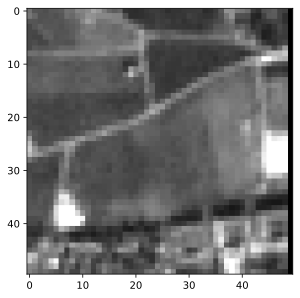

In [35]:
plt.imshow(test['arr_shifted'][-50:, -50:], vmin=0, vmax=1000, cmap='gray')

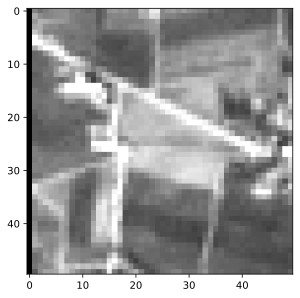

In [20]:
plt.imshow(translated_data_array[0, :50, :50], vmin=0, vmax=1000, cmap='gray')

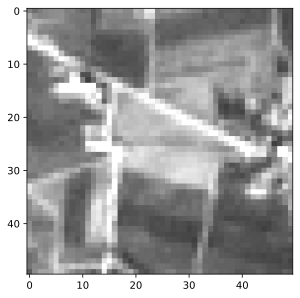

In [21]:
plt.imshow(target_images.isel(time=0).s2_B04.values[:50, :50], vmin=0, vmax=1000, cmap='gray')

# GLOBAL coregistration

### Coregister single image 
- need to make it skip/work if the image is fully cloudy --> use mask_baddata_tgt and mask_baddata_ref 

In [21]:
from arosics import COREG
from arosics import DESHIFTER

In [11]:
# Loop through each target image and perform coregistration
for i in range(target_images.sizes['time']):
    target_image = target_images.isel(time=i)
    
    # Initialize the COREG object
    CR = COREG(
        im_ref=reference_image.values,  # Reference image array
        im_tgt=target_image.values,     # Target image array
        ws=(128, 128),           # Size of the matching window
        max_iter=5,             # Maximum number of iterations
        path_out=None,           # Path to save the coregistered image (None if not saving)
        fmt_out='Zarr',             # Output format (None if not saving)
        nodata = (65535, 65535)
    )

    # Perform coregistration
    CR.calculate_spatial_shifts()
    corrected_dict = CR.correct_shifts() # returns an OrderedDict containing the co-registered numpy array and its corresponding geoinformation.


    # If you want to save the corrected image or do further processing,
    # proceed with your own logic here.


    break

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -640.0, 640.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -640.0, 640.0, 0.0)
Matching window position (X,Y): 320.0/-320.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.17132730131404147/-0.03840223521423738
Calculated total shifts in fft pixel units (X/Y):         -0.17132730131404147/-0.03840223521423738
Calculated total shifts in reference pixel units (X/Y):   -0.17132730131404147/-0.03840223521423738
Calculated total shifts in target pixel units (X/Y):      -0.17132730131404147/-0.03840223521423738
Calculated map shifts (X,Y):				  -0.17132730131404147/0.03840223521423738
Calculated absolute shift vector length in map units:     0.1755

In [12]:
corrected_dict['arr_shifted']

array([[ 574,  574,  603, ...,  612,  460,  486],
       [ 622,  622,  621, ...,  388,  458,  805],
       [ 693,  693,  691, ...,  359,  755, 1307],
       ...,
       [1300, 1300, 1401, ...,  122,  105,   81],
       [1525, 1525, 1670, ...,  262,  268,  250],
       [1647, 1647, 1806, ...,  306,  304,  317]], dtype=uint16)

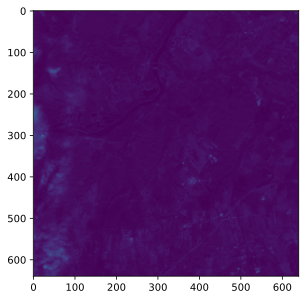

In [13]:
plt.imshow(corrected_dict['arr_shifted'])

### Coregister all bands of a timestep

In [9]:
from arosics import DESHIFTER

In [16]:
corrected_B02 = DESHIFTER(ds.isel(time=slice(2, None)).s2_B02.isel(time=0).values, CR.coreg_info).correct_shifts()

Correcting geometric shifts...
NOTE: The detected shift is corrected by updating the map info of the target image only, i.e., without any resampling. Set the 'align_grids' parameter to True if you need the target and the reference coordinate grids to be aligned.


# LOCAL coregistration

In [8]:
from arosics import COREG_LOCAL
from geoarray import GeoArray
from pyproj import CRS

In [44]:
# Convert reference image to GeoArray
geotransform = (ds.lon.min().values, 10, 0, ds.lat.max().values, 0, -10)
projection = CRS.from_epsg(32632).to_wkt()
geo_ref_image = GeoArray(reference_image.values, geotransform=geotransform, projection=projection)

In [45]:
# Loop through each target image and perform coregistration
for i in range(target_images.sizes['time']):
    target_image = target_images.isel(time=i)
    geo_tgt_image = GeoArray(target_image.values, geotransform=geotransform, projection=projection)


    # Initialize the COREG object
    CR = COREG_LOCAL(
        im_ref=geo_ref_image,  # Reference image array
        im_tgt=geo_tgt_image,     # Target image array
        grid_res=10,           # Target grid resolution
        window_size=(256,256),        # Size of the matching window
        fmt_out='Zarr',
        nodata=(65535,65535)
    )

    # Perform coregistration
    corrected_dict = CR.correct_shifts() # returns an OrderedDict containing the co-registered numpy array and its corresponding geoinformation.


    # If you want to save the corrected image or do further processing,
    # proceed with your own logic here.


    break

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(262620.0, 5109420.0, 269020.0, 5115820.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(262620.0, 5109420.0, 269020.0, 5115820.0)
Matching window position (X,Y): 265820.0/5112620.0
Initializing tie points grid...
Calculating tie point grid (4225 points) using 64 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:21


Found 4224 matches.
Performing validity checks...
104 tie points flagged by level 1 filtering (reliability).
506 tie points flagged by level 2 filtering (SSIM).


Translating progress |==================================================| 100.0% Complete  => 0:00:00


379 tie points flagged by level 3 filtering (RANSAC)
3266 valid tie points remain after filtering.
Correcting geometric shifts...


In [46]:
CR.CoRegPoints_table

geometry  POINT_ID  X_IM  Y_IM     X_MAP      Y_MAP  \
0     POINT (262620 5115820)         0     0     0  262620.0  5115820.0   
1     POINT (262720 5115820)         1    10     0  262720.0  5115820.0   
2     POINT (262820 5115820)         2    20     0  262820.0  5115820.0   
3     POINT (262920 5115820)         3    30     0  262920.0  5115820.0   
4     POINT (263020 5115820)         4    40     0  263020.0  5115820.0   
...                      ...       ...   ...   ...       ...        ...   
4220  POINT (268620 5109420)      4220   600   640  268620.0  5109420.0   
4221  POINT (268720 5109420)      4221   610   640  268720.0  5109420.0   
4222  POINT (268820 5109420)      4222   620   640  268820.0  5109420.0   
4223  POINT (268920 5109420)      4223   630   640  268920.0  5109420.0   
4224  POINT (269020 5109420)      4224   640   640  269020.0  5109420.0   

      REF_BADDATA  TGT_BADDATA  X_WIN_SIZE  Y_WIN_SIZE  ...       ANGLE  \
0           False        False       126.0       126.0  ...  314.708470   
1           False        False       136.0       126.0  ...  298.948080   
2           False        False       146.0       126.0  ...  297.356216   
3           False        False       156.0       126.0  ...  232.840024   
4           False        False       166.0       126.0  ...  225.167133   
...           ...          ...         ...         ...  ...         ...   
4220        False        False       166.0       126.0  ...  230.724681   
4221        False        False       156.0       126.0  ...  244.575341   
4222        False        False       146.0       126.0  ...  246.715936   
4223        False        False       136.0       126.0  ...  287.971292   
4224        False        False       126.0       126.0  ...  255.162326   

      SSIM_BEFORE  SSIM_AFTER  SSIM_IMPROVED  RELIABILITY  LAST_ERR  \
0        0.404012    0.413855           True    65.339616     -9999   
1        0.411552    0.419809           True    65.864208     -9999   
2        0.424786    0.433986           True    68.118222     -9999   
3        0.429096    0.428152          False    66.610721     -9999   
4        0.435057    0.433080          False    65.045057     -9999   
...           ...         ...            ...          ...       ...   
4220     0.486738    0.491529           True    72.929318     -9999   
4221     0.479188    0.483219           True    71.530306     -9999   
4222     0.469034    0.472667           True    69.781626     -9999   
4223     0.462179    0.467192           True    68.466386     -9999   
4224     0.450811    0.453346           True    69.242210     -9999   

      L1_OUTLIER  L2_OUTLIER L3_OUTLIER  OUTLIER  
0          False       False      False    False  
1          False       False      False    False  
2          False       False      False    False  
3          False        True      False     True  
4          False        True      False     True  
...          ...         ...        ...      ...  
4220       False       False      False    False  
4221       False       False      False    False  
4222       False       False      False    False  
4223       False       False      False    False  
4224       False       False      False    False  

[4225 rows x 25 columns]

In [47]:
corrected_dict['arr_shifted']

array([[ 574,  574,  599, ...,  576,  475,  512],
       [ 615,  615,  618, ...,  368,  450,  815],
       [ 683,  683,  685, ...,  426,  757, 1280],
       ...,
       [1302, 1302, 1359, ...,  122,  109,   87],
       [1490, 1490, 1621, ...,  264,  268,  253],
       [1628, 1628, 1765, ...,  296,  304,  316]], dtype=uint16)

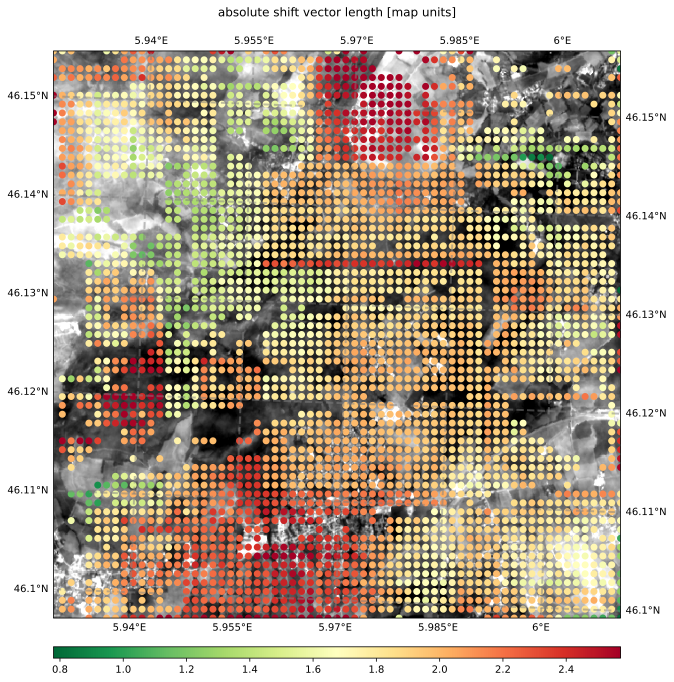

In [50]:
CR.view_CoRegPoints(figsize=(10,10), backgroundIm='ref')

# Pipeline

In [6]:
from arosics import COREG, COREG_LOCAL
from geoarray import GeoArray
from arosics import COREG
from arosics import DESHIFTER
from pyproj import CRS
from shapely import Polygon

In [7]:
bands = ['s2_B02', 's2_B03', 's2_B04', 's2_B05', 's2_B06', 's2_B07', 's2_B08', 's2_B8A', 's2_B11', 's2_B12']

reference_image = ds.isel(time=0).s2_B04
target_images = ds[bands].compute()

In [8]:
ds_coreg = ds.copy()

In [9]:
# Convert ref and target to GeoArray with some geo information
geotransform = (ds.lon.min().values, 10, 0, ds.lat.max().values, 0, -10)
projection = CRS.from_epsg(32632).to_wkt()
geo_ref_image = GeoArray(reference_image.values, geotransform=geotransform, projection=projection)

In [10]:
# Image footprint
minx, miny, maxx, maxy = [ds.lon.min(), ds.lat.min()-10, ds.lon.max()+10, ds.lat.max()]
footprint = Polygon([(maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy), (maxx, maxy)])

In [28]:
# Global coregistration

for i in range(target_images.sizes['time']):
    
    print(f'Coregistering image {i}, time {str(ds.time.values[i])}')
    
    target_image = target_images.isel(time=i)
    geo_tgt_image = GeoArray(target_image.to_array().values.transpose(1, 2, 0), geotransform=geotransform, projection=projection)
    
    # Pass cloud mask
    scl = ds.isel(time=i).s2_SCL
    scl_mask = xr.where(scl.isin([0,1,2,3,7,8,9,10]), True, False) 
    cloud = ds.isel(time=i).s2_mask
    cloud_mask = xr.where(cloud != 0, True, False)
    data_mask = scl_mask & cloud_mask
    
    # Check if there is any data
    print(f'Clouds masked {data_mask.values.sum()}/{data_mask.shape[0]*data_mask.shape[1]}')
    print(f'Missing data: {np.sum(target_image.values == 65535)}')
    if not data_mask.values.sum() == data_mask.shape[0]*data_mask.shape[1]: 
        try:

            # Initialize the COREG object
            CR = COREG(
                im_ref=geo_ref_image,  # Reference image array
                im_tgt=geo_tgt_image, #target_image.to_array().values.transpose(1, 2, 0),     # Target image array
                ws=(256, 256),           # Size of the matching window
                max_iter=10,             # Maximum number of iterations
                path_out=None,           # Path to save the coregistered image (None if not saving)
                fmt_out='Zarr',             # Output format (None if not saving)
                nodata = (65535, 65535),
                #mask_baddata_tgt= data_mask.values,
                footprint_poly_ref=footprint,
                footprint_poly_tgt=footprint
            )

            # Perform coregistration
            CR.calculate_spatial_shifts()
            corrected_dict = CR.correct_shifts() # returns an OrderedDict containing the co-registered numpy array and its corresponding geoinformation.
        
            # Update ds_coreg at time i with coregistered values
            for band in bands:
                ds_coreg[band].isel(time=i).values[:] = corrected_dict['arr_shifted'][:, :, bands.index(band)]

        except Exception as e:
            print(f'Error: {e}')
            pass
  

Coregistering image 0, time 2019-01-03T00:00:00.000000000
Clouds masked 0/409600
Missing data: 0
Bounding box of calculated footprint for reference image:
	(262620.0, 5109420.0, 269020.0, 5115820.0)
Bounding box of calculated footprint for image to be shifted:
	(262620.0, 5109420.0, 269020.0, 5115820.0)
Matching window position (X,Y): 265820.0/5112620.0
Detected integer shifts (X/Y):                            0/0
Detected subpixel shifts (X/Y):                           -0.1844004927846295/-0.044037818257732404
Calculated total shifts in fft pixel units (X/Y):         -0.1844004927846295/-0.044037818257732404
Calculated total shifts in reference pixel units (X/Y):   -0.1844004927846295/-0.044037818257732404
Calculated total shifts in target pixel units (X/Y):      -0.1844004927846295/-0.044037818257732404
Calculated map shifts (X,Y):				  -1.8440049278433435/0.44037818256765604
Calculated absolute shift vector length in map units:     1.8958605216608437
Calculated angle of shift vecto

In [ ]:
# Local coregistration

for i in range(target_images.sizes['time']):
    
    print(f'Coregistering image {i}, time {str(ds.time.values[i])}')
    
    target_image = target_images.isel(time=i)
    geo_tgt_image = GeoArray(target_image.to_array().values.transpose(1, 2, 0), geotransform=geotransform, projection=projection)
    
    # Pass cloud mask
    scl = ds.isel(time=i).s2_SCL
    scl_mask = xr.where(scl.isin([0,1,2,3,7,8,9,10]), True, False) 
    cloud = ds.isel(time=i).s2_mask
    cloud_mask = xr.where(cloud != 0, True, False)
    data_mask = scl_mask & cloud_mask
    
    # Check if there is any data
    print(f'Clouds masked {data_mask.values.sum()}/{data_mask.shape[0]*data_mask.shape[1]}')
    print(f'Missing data: {np.sum(target_image.values == 65535)}')
    if not data_mask.values.sum() == data_mask.shape[0]*data_mask.shape[1]: 
        try:

            # Initialize the COREG object
            CR = COREG_LOCAL(
                im_ref=geo_ref_image,  # Reference image array
                im_tgt=geo_tgt_image,     # Target image array
                grid_res=10,           # Target grid resolution
                window_size=(256,256),        # Size of the matching window
                fmt_out='Zarr',
                nodata=(65535,65535),
                footprint_poly_ref=footprint,
                footprint_poly_tgt=footprint
            )

            # Perform coregistration
            corrected_dict = CR.correct_shifts() # returns an OrderedDict containing the co-registered numpy array and its corresponding geoinformation.
        
            # Update ds_coreg at time i with coregistered values
            for band in bands:
                ds_coreg[band].isel(time=i).values[:] = corrected_dict['arr_shifted'][:, :, bands.index(band)]

        except Exception as e:
            print(f'Error: {e}')
            pass
  

In [142]:
ds_coreg.isel(time=2).s2_B02.values

array([[ 495,  495,  538, ...,  241,  256,  240],
       [ 476,  476,  502, ...,  238,  239,  667],
       [ 572,  572,  513, ...,  267,  522, 1236],
       ...,
       [ 934,  934,  993, ...,    1,    1,    1],
       [1209, 1209, 1327, ...,   60,  145,    5],
       [1305, 1305, 1443, ...,  112,  128,  122]], dtype=uint16)

In [143]:
corrected_dict['arr_shifted'][:,:,0]

array([[ 495,  495,  538, ...,  241,  256,  240],
       [ 476,  476,  502, ...,  238,  239,  667],
       [ 572,  572,  513, ...,  267,  522, 1236],
       ...,
       [ 934,  934,  993, ...,    1,    1,    1],
       [1209, 1209, 1327, ...,   60,  145,    5],
       [1305, 1305, 1443, ...,  112,  128,  122]], dtype=uint16)

# Save as gif


In [30]:
from PIL import Image

In [31]:
rgb_coreg = ds_coreg[['s2_B04','s2_B03','s2_B02']]

In [32]:
# Need to rescale each band to 0-255 and then set the nan values to 255
max_vals = rgb_coreg.max(dim=['time', 'lat', 'lon'])
min_vals = rgb_coreg.min(dim=['time', 'lat', 'lon'])
rgb_scaled = ((rgb_coreg - min_vals) / (max_vals - min_vals)) * 255.0
rgb_coreg = rgb_scaled.where(~rgb_scaled.isnull(), 0)

In [33]:
# Save a gif of coregistered data

# Create a PIL Image object from the numpy array
gif = []
for t in range(rgb_coreg.sizes['time']):
    img = rgb_coreg.isel(time=t).to_array().values.transpose(1,2,0)
   
    """
    # Rescale data to 0-255
    im_rescaled = np.zeros_like(img, dtype='uint8')
    for band in range(3):
        band_arr = img[:, :, band]
        min_val = band_arr.min()
        max_val = band_arr.max()
        b_rescaled = ((band_arr - min_val) * (255 / (max_val - min_val))).astype("uint8")
        im_rescaled[:, :, band] = b_rescaled
    """
    im_rescaled = img*3


    # Convert numpy array to PIL Image and resize
    pil_img = Image.fromarray(im_rescaled.astype("uint8")).resize((800, 600))
    gif.append(pil_img)


# Save the GIF
gif[0].save('arosics_coreg_si.gif',
            save_all=True,
            append_images=gif[1:],
            duration=500,  # Set duration between frames in milliseconds
            loop=0)  # Set loop to 0 for infinite looping

In [23]:
# Save a gif of  original data

rgb = ds[['s2_B04','s2_B03','s2_B02']]


# Need to rescale each band to 0-255 and then set the nan values to 255
max_vals = rgb.max(dim=['time', 'lat', 'lon'])
min_vals = rgb.min(dim=['time', 'lat', 'lon'])
rgb_scaled = ((rgb - min_vals) / (max_vals - min_vals)) * 255.0
rgb = rgb_scaled.where(~rgb_scaled.isnull(), 0)

# Create a PIL Image object from the numpy array
gif = []
for t in range(rgb.sizes['time']):
    img = rgb.isel(time=t).to_array().values.transpose(1,2,0)
    im_rescaled = img*3

    # Convert numpy array to PIL Image and resize
    pil_img = Image.fromarray(im_rescaled.astype("uint8")).resize((800, 600))
    gif.append(pil_img)


# Save the GIF
gif[0].save('arosics_original_si.gif',
            save_all=True,
            append_images=gif[1:],
            duration=500,  # Set duration between frames in milliseconds
            loop=0)  # Set loop to 0 for infinite looping

In [33]:
# Plot orig and coreg side by side

rgb_coreg = ds_coreg[['s2_B04','s2_B03','s2_B02']]

# Need to rescale each band to 0-255 and then set the nan values to 255
max_vals = rgb_coreg.max(dim=['time', 'lat', 'lon'])
min_vals = rgb_coreg.min(dim=['time', 'lat', 'lon'])
rgb_scaled = ((rgb_coreg - min_vals) / (max_vals - min_vals)) * 255.0
rgb_coreg = rgb_scaled.where(~rgb_scaled.isnull(), 0)


rgb = ds[['s2_B04','s2_B03','s2_B02']]

# Need to rescale each band to 0-255 and then set the nan values to 255
max_vals = rgb.max(dim=['time', 'lat', 'lon'])
min_vals = rgb.min(dim=['time', 'lat', 'lon'])
rgb_scaled = ((rgb - min_vals) / (max_vals - min_vals)) * 255.0
rgb = rgb_scaled.where(~rgb_scaled.isnull(), 0)


# Create a PIL Image object from the numpy array
gif = []
for t in range(rgb.sizes['time']):
    img_orig = rgb.isel(time=t).to_array().values.transpose(1,2,0)
    im_rescaled_orig = img_orig*3

    img_coreg = rgb_coreg.isel(time=t).to_array().values.transpose(1,2,0)
    im_rescaled_coreg = img_coreg*3

    # Combine the original and coregistered images side by side
    combined_img = np.hstack((im_rescaled_orig, im_rescaled_coreg))

    # Convert numpy array to PIL Image and resize
    pil_img = Image.fromarray(combined_img.astype("uint8")).resize((1600, 600))  # Resize to twice the width
    gif.append(pil_img)


# Save the GIF
gif[0].save('arosics_global_origvscoreg_si.gif',
            save_all=True,
            append_images=gif[1:],
            duration=500,  # Set duration between frames in milliseconds
            loop=0)  # Set loop to 0 for infinite looping